In [2]:
import numpy as np
import random
import torch
import torch.nn as nn
from collections import deque
from pettingzoo.sisl import pursuit_v4
import supersuit as ss

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import random
from collections import deque
import numpy as np
import time

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class CNN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(CNN, self).__init__()
        c, h, w = input_shape  # c = canales, h = alto, w = ancho
        self.net = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * h * w, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, size):
        self.buffer = deque(maxlen=size)

    def add(self, *transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            torch.as_tensor(np.stack(states), dtype=torch.float32),
            torch.as_tensor(actions, dtype=torch.long),
            torch.as_tensor(rewards, dtype=torch.float32),
            torch.as_tensor(np.stack(next_states), dtype=torch.float32),
            torch.as_tensor(dones, dtype=torch.float32)
        )

    def __len__(self):
        return len(self.buffer)


class DQN:
    def __init__(self,
            env,
            learning_rate = 1e-3,
            buffer_size = 300000,
            learning_starts = 100,
            batch_size = 32,
            tau = 1.0,
            gamma = 0.99,
            train_freq = 4,
            gradient_steps = 1,
            target_update_interval = 10000,
            exploration_fraction = 0.1,
            exploration_initial_eps = 1.0,
            exploration_final_eps = 0.05,
            max_grad_norm = 10,
            verbose = 0
        ):
        
        self.env = env
        self.device = torch.device("mps" if torch.mps.is_available() else "cpu")
        example_agent = env.agents[0]
        self.obs_dim = env.observation_space(example_agent).shape[0]
        self.n_actions = env.action_space(example_agent).n

        self.policy = CNN(input_shape=(3, 7, 7), n_actions=self.n_actions).to(self.device)
        self.target_policy = CNN(input_shape=(3, 7, 7), n_actions=self.n_actions).to(self.device)
        self.target_policy.load_state_dict(self.policy.state_dict())
        self.target_policy.eval()

        self.optimizer = optim.Adam(self.policy.parameters(), lr=learning_rate, betas=(0.9, 0.999))
        self.replay_buffer = ReplayBuffer(buffer_size)

        self.learning_starts = learning_starts
        self.batch_size = batch_size
        self.tau = tau
        self.gamma = gamma
        self.train_freq = train_freq
        self.gradient_steps = gradient_steps
        self.target_update_interval = target_update_interval
        self.exploration_initial_eps = exploration_initial_eps
        self.exploration_final_eps = exploration_final_eps
        self.exploration_fraction = exploration_fraction
        self.max_grad_norm = max_grad_norm
        self.verbose = verbose

        self.epsilon = self.exploration_initial_eps
        self.last_loss = None
        self.num_updates = 0


    def _select_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_actions)
        state = torch.FloatTensor(state).permute(2, 0, 1).unsqueeze(0).to(self.device)  # (7,7,3) -> (1,3,7,7)
        with torch.no_grad():
            act_values = self.policy(state)
        return torch.argmax(act_values[0]).item()

    def _train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        self.policy.train()

        total_loss = 0
        for _ in range(self.gradient_steps):
            states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
            # Permutar para que las dimensiones sean (batch_size, channels, height, width)
            states = states.permute(0, 3, 1, 2).to(self.device)
            actions = actions.to(self.device)
            rewards = rewards.to(self.device)
            next_states = next_states.permute(0, 3, 1, 2).to(self.device)
            dones = dones.to(self.device)

            q_values = self.policy(states).gather(1, actions.unsqueeze(1)).squeeze(1)

            with torch.no_grad():
                next_q_values = self.target_policy(next_states).max(1)[0]
                expected_q = rewards + self.gamma * next_q_values * (1 - dones)

            loss = F.smooth_l1_loss(q_values, expected_q)
            self.last_loss = loss.item()

            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.optimizer.step()

            self.num_updates += 1

            total_loss += loss.item()
        
        return total_loss / self.gradient_steps

    def learn(self, total_timesteps, log_interval=1000):
        obs, _ = self.env.reset()
        state = np.asarray(obs, dtype=np.float32)
        start_t  = time.perf_counter()
        ep_count = 0
        ep_lens  = deque(maxlen=100)
        ep_rews  = deque(maxlen=100)
        episode_reward = 0
        eps_decay_steps = int(self.exploration_fraction * total_timesteps)

        for t in range(1, total_timesteps + 1):
            self.total_timesteps = t
            self.epsilon = max(
                self.exploration_final_eps,
                self.exploration_initial_eps - (self.exploration_initial_eps - self.exploration_final_eps) * (t / eps_decay_steps)
            )

            action = self._select_action(state)
            next_state, reward, terminated, truncated, info = self.env.step(action)
            #reward = np.clip(reward, -1.0, 1.0)
            done = terminated or truncated
            next_state = np.asarray(next_state, dtype=np.float32)
            self.replay_buffer.add(state, action, reward, next_state, float(done))
            state = next_state
            episode_reward += reward

            if "episode" in info:
                ep_len = info["episode"]["l"]
                ep_rew = info["episode"]["r"]
                ep_lens.append(ep_len)
                ep_rews.append(ep_rew)
                ep_count += 1

            ## Fin del episodio
            if done:
                last_ep_reward = episode_reward
                obs, _ = self.env.reset()
                state = np.asarray(obs, dtype=np.float32)
                episode_reward = 0

            ## Cuándo se entrena la red
            if t > self.learning_starts and t % self.train_freq == 0:
                self._train_step()

            ## Sincronización de red target
            if self.num_updates > 0 and self.num_updates % self.target_update_interval == 0:
                self.target_policy.load_state_dict(self.policy.state_dict())
                self.target_policy.eval()

            if self.verbose and ep_count > 0 and ep_count % log_interval == 0 and done:
                fps = int(t / (time.perf_counter() - start_t))
                lr = self.optimizer.param_groups[0]["lr"]
                loss = self.last_loss if self.last_loss is not None else float("nan")
                print("----------------------------------")
                print(f"| rollout/            |          |")
                print(f"|    ep_len_mean      | {np.mean(ep_lens) if ep_lens else float('nan'):.0f}")
                print(f"|    ep_rew_mean      | {np.mean(ep_rews) if ep_rews else float('nan'):.0f}")
                print(f"|    exploration_rate | {self.epsilon:.3f}")
                print(f"| time/               |          |")
                print(f"|    episodes         | {ep_count}")
                print(f"|    fps              | {fps}")
                print(f"|    time_elapsed     | {int(time.perf_counter() - start_t)}")
                print(f"|    total_timesteps  | {t}")
                print(f"| train/              |          |")
                print(f"|    learning_rate    | {lr:.3g}")
                print(f"|    loss             | {loss:.4f}")
                print(f"|    n_updates        | {self.num_updates}")
                print("----------------------------------")

In [13]:
def learn_multiagent(env, agent_dict, total_timesteps, log_interval=1000):
    observations, _ = env.reset()
    episode_reward = {agent: 0 for agent in env.agents}
    ep_lens = deque(maxlen=100)
    ep_len = 0
    ep_rews = {agent: deque(maxlen=100) for agent in agent_dict}
    ep_count = 0
    t = 0
    start_t = time.perf_counter()

    eps_decay_steps = int(list(agent_dict.values())[0].exploration_fraction * total_timesteps)

    episode_rewards = []
    losses = []

    last_logged = -1

    while t < total_timesteps:
        actions = {}

        total_rewards = {agent: 0 for agent in env.agents}
        total_losses = {agent: 0 for agent in env.agents}

        for agent in env.agents:
            if agent in agent_dict:
                dqn = agent_dict[agent]
                dqn.epsilon = max(
                    dqn.exploration_final_eps,
                    dqn.exploration_initial_eps - (dqn.exploration_initial_eps - dqn.exploration_final_eps) * (t / eps_decay_steps)
                )
                action = dqn._select_action(observations[agent])
                actions[agent] = action
            else:
                actions[agent] = 0  # good agent se queda quieto

        next_obs, rewards, terminations, truncations, infos = env.step(actions)

        for agent in agent_dict:
            done = terminations[agent] or truncations[agent]
            dqn = agent_dict[agent]

            dqn.replay_buffer.add(
                np.array(observations[agent], dtype=np.float32),
                actions[agent],
                rewards[agent],
                np.array(next_obs[agent], dtype=np.float32),
                float(done)
            )
            episode_reward[agent] += rewards[agent]

            if t > dqn.learning_starts and t % dqn.train_freq == 0:
                loss = dqn._train_step()
                total_losses[agent] += loss if loss is not None else 0

            if dqn.num_updates > 0 and dqn.num_updates % dqn.target_update_interval == 0:
                dqn.target_policy.load_state_dict(dqn.policy.state_dict())
                dqn.target_policy.eval()

        losses.append(total_losses)

        t += 1
        observations = next_obs
        ep_len += 1
        # Fin de episodio
        if terminations["pursuer_0"] or truncations["pursuer_0"]:
            episode_rewards.append(episode_reward.copy())

            for agent in agent_dict:
                ep_rews[agent].append(episode_reward[agent])
                episode_reward[agent] = 0
            
            ep_lens.append(ep_len)  # si no tienes env.env_done_step puedes usar len(env.dones)
            ep_len = 0
            observations, _ = env.reset()
            ep_count += 1

        # Logging
        if ep_count > 0 and ep_count % log_interval == 0 and ep_count != last_logged:
            last_logged = ep_count
            fps = int(t / (time.perf_counter() - start_t))
            print("----------------------------------")
            print(f"| time/               |          |")
            print(f"|    episodes         | {ep_count}")
            print(f"|    fps              | {fps}")
            print(f"|    time_elapsed     | {int(time.perf_counter() - start_t)}")
            print(f"|    total_timesteps  | {t}")
            print(f"|    ep_len_mean      | {np.mean(ep_lens) if ep_lens else float('nan'):.0f}")
            for agent in agent_dict:
                dqn = agent_dict[agent]
                loss = dqn.last_loss if dqn.last_loss is not None else float("nan")
                print(f"| {agent} -> mean_ep_rew | {np.mean(ep_rews[agent]):.2f} | loss: {loss:.4f} | eps: {dqn.epsilon:.3f}")
            print("----------------------------------")

    return episode_rewards, losses

In [14]:
import matplotlib.pyplot as plt

def plot_total_rewards(rewards_dict_per_episode):
    """
    rewards_dict_per_episode: list de dicts por episodio, ej:
    [{agent_0: 10, agent_1: 12}, {agent_0: 5, agent_1: 7}, ...]
    """

    # llevar a cpu
    agent_names = rewards_dict_per_episode[0].keys()
    episode_count = len(rewards_dict_per_episode)

    for agent in agent_names:
        rewards = [episode[agent].cpu().item() if torch.is_tensor(episode[agent]) else episode[agent] for episode in rewards_dict_per_episode]
        plt.plot(rewards, label=agent)

    plt.xlabel("Episodio")
    plt.ylabel("Reward total por agente")
    plt.title("Recompensas por episodio")
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
# Crear entorno paralelo
seed = 42
env = pursuit_v4.parallel_env(render_mode='rgb_array', x_size=7, y_size=7, n_pursuers=4, n_evaders=10)
env.reset(seed=seed)
agents = env.agents
example_agent = env.agents[0]
print("Obs shape for", example_agent, ":", env.observation_space(example_agent).shape)

dqn_params = {
    "learning_rate": 1e-3,
    "buffer_size": 5000,
    "learning_starts": 500,
    "batch_size": 128,
    "tau": 1.0,
    "gamma": 0.99,
    "train_freq": 1,
    "gradient_steps": 1,
    "target_update_interval": 500,
    "exploration_fraction": 0.1,
    "exploration_initial_eps": 1,
    "exploration_final_eps": 0.1,
    "max_grad_norm": 10,
    "verbose": 1,
}

# Inicializar agentes solo para los adversarios
agent_dict = {
    agent: DQN(env, **dqn_params)
    for agent in agents if agent.startswith("pursuer")
}

# Entrenar los agentes adversarios
episode_rewards, episode_losses = learn_multiagent(env, agent_dict, total_timesteps=50000, log_interval=10)


Obs shape for pursuer_0 : (7, 7, 3)
----------------------------------
| time/               |          |
|    episodes         | 10
|    fps              | 38
|    time_elapsed     | 130
|    total_timesteps  | 5000
|    ep_len_mean      | 500
| pursuer_0 -> mean_ep_rew | -34.02 | loss: 0.0134 | eps: 0.100
| pursuer_1 -> mean_ep_rew | -34.02 | loss: 0.0079 | eps: 0.100
| pursuer_2 -> mean_ep_rew | -34.02 | loss: 0.0583 | eps: 0.100
| pursuer_3 -> mean_ep_rew | -34.02 | loss: 0.0364 | eps: 0.100
----------------------------------
----------------------------------
| time/               |          |
|    episodes         | 20
|    fps              | 34
|    time_elapsed     | 286
|    total_timesteps  | 10000
|    ep_len_mean      | 500
| pursuer_0 -> mean_ep_rew | -30.96 | loss: 0.0061 | eps: 0.100
| pursuer_1 -> mean_ep_rew | -30.96 | loss: 0.0087 | eps: 0.100
| pursuer_2 -> mean_ep_rew | -30.96 | loss: 0.0244 | eps: 0.100
| pursuer_3 -> mean_ep_rew | -30.96 | loss: 0.0138 | eps: 0.10

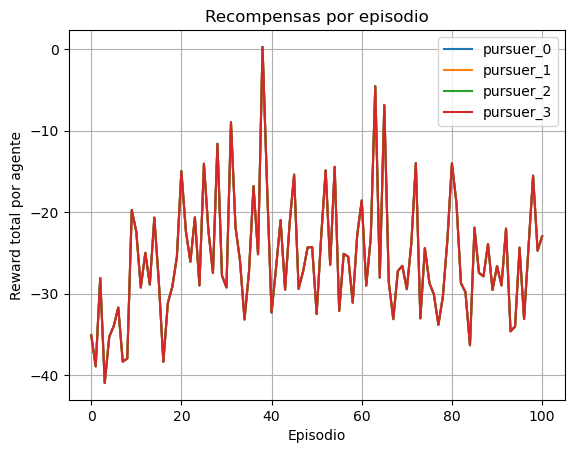

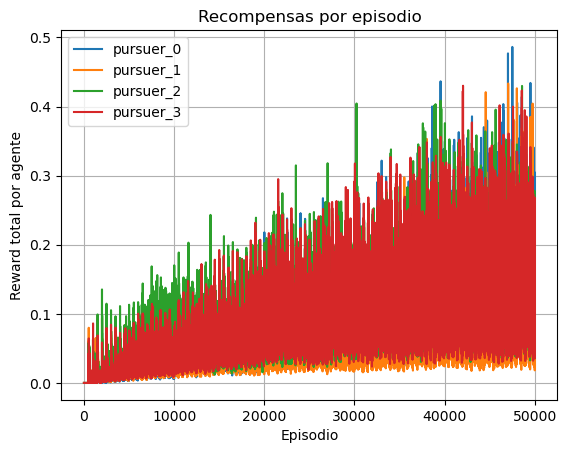

In [27]:
plot_total_rewards(episode_rewards)
plot_total_rewards(episode_losses)  # Graficar las pérdidas por episodio

In [28]:
def evaluate_agent_parallel(env, agent_dict, episodes=5):
    rewards = []

    for agent in agent_dict.values():
        agent.epsilon = 0  # Evaluación sin exploración

    for _ in range(episodes):
        observations, _ = env.reset()
        total_rewards = {agent: 0 for agent in env.agents}
        terminated = {agent: False for agent in env.agents}
        truncated = {agent: False for agent in env.agents}

        while not all(terminated[agent] or truncated[agent] for agent in env.agents):
            actions = {}
            for agent in env.agents:
                if terminated[agent] or truncated[agent]:
                    continue
                if agent in agent_dict:
                    actions[agent] = agent_dict[agent]._select_action(observations[agent])
                else:
                    actions[agent] = 0  # El agente bueno se queda quieto

            observations, rewards_step, terminated_step, truncated_step, _ = env.step(actions)

            for agent in env.agents:
                total_rewards[agent] += rewards_step[agent]
                terminated[agent] = terminated_step[agent]
                truncated[agent] = truncated_step[agent]

        rewards.append(total_rewards)

    return rewards


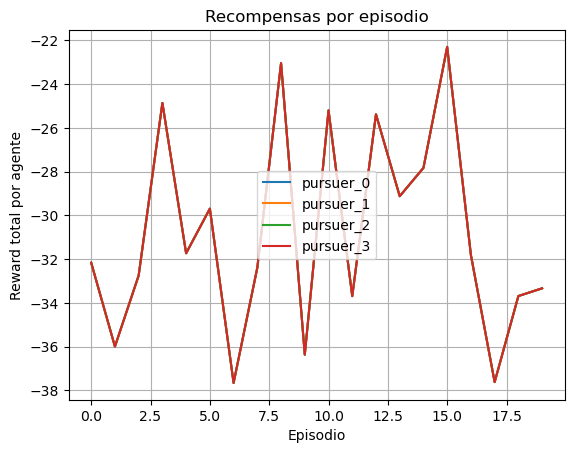

In [29]:
rewards_2 = evaluate_agent_parallel(env, agent_dict, episodes = 20)
plot_total_rewards(rewards_2)

In [30]:
import imageio
import numpy as np
from PIL import Image

def evaluate_multiagent_render_parallel(agent_dict, env, num_tests=1, save_path="multiagent_episode.mp4", fps=5, max_steps=500):
    all_frames = []

    # Política determinista: desactiva exploración
    for agent in agent_dict.values():
        agent.epsilon = 0.0

    for _ in range(num_tests):
        observations, _ = env.reset()
        terminated = {agent: False for agent in env.agents}
        truncated = {agent: False for agent in env.agents}
        frames = []
        step_count = 0

        while not all(terminated[agent] or truncated[agent] for agent in env.agents) and step_count < max_steps:
            actions = {}
            for agent in env.agents:
                if terminated[agent] or truncated[agent]:
                    continue
                if agent in agent_dict:
                    actions[agent] = agent_dict[agent]._select_action(observations[agent])
                else:
                    actions[agent] = 0  # agente bueno quieto

            observations, _, terminated_step, truncated_step, _ = env.step(actions)

            for agent in env.agents:
                terminated[agent] = terminated_step[agent]
                truncated[agent] = truncated_step[agent]

            frame = env.render()
            frame_resized = np.array(Image.fromarray(frame).resize((240, 240)))
            frames.append(frame_resized)
            step_count += 1

        all_frames.extend(frames + [frames[-1]] * 5)  # padding final

    imageio.mimsave(save_path, all_frames, fps=fps)
    print(f"Video guardado en: {save_path}")


In [31]:
evaluate_multiagent_render_parallel(agent_dict, env, num_tests=5, save_path="multiagent_episode_purusuit.mp4", fps=5, max_steps=50)

Video guardado en: multiagent_episode_purusuit.mp4


# 2 Agents

In [80]:
# Crear entorno paralelo
seed = 42
env = simple_spread_v3.parallel_env(render_mode='rgb_array', N=2, local_ratio = 0.5, max_cycles=25, dynamic_rescaling=True)
env.reset(seed=seed)
agents = env.agents

dqn_params = {
    "learning_rate": 1e-3,
    "buffer_size": 10000,
    "learning_starts": 1000,
    "batch_size": 128,
    "tau": 1.0,
    "gamma": 0.99,
    "train_freq": 16,
    "gradient_steps": 4,
    "target_update_interval": 1000,
    "exploration_fraction": 0.1,
    "exploration_initial_eps": 1,
    "exploration_final_eps": 0.1,
    "max_grad_norm": 10,
    "verbose": 1,
}

# Inicializar agentes solo para los adversarios
agent_dict = {
    agent: DQN(env, **dqn_params)
    for agent in agents if agent.startswith("agent")
}

# Entrenar los agentes adversarios
episode_rewards2, episode_losses2 = learn_multiagent(env, agent_dict, total_timesteps=100000, log_interval=100)

----------------------------------
| time/               |          |
|    episodes         | 100
|    fps              | 640
|    time_elapsed     | 3
|    total_timesteps  | 2500
|    ep_len_mean      | 25
| agent_0 -> mean_ep_rew | -21.82 | loss: 0.0091 | eps: 0.775
| agent_1 -> mean_ep_rew | -21.82 | loss: 0.0066 | eps: 0.775
----------------------------------
----------------------------------
| time/               |          |
|    episodes         | 200
|    fps              | 501
|    time_elapsed     | 9
|    total_timesteps  | 5000
|    ep_len_mean      | 25
| agent_0 -> mean_ep_rew | -21.66 | loss: 0.0040 | eps: 0.550
| agent_1 -> mean_ep_rew | -21.66 | loss: 0.0043 | eps: 0.550
----------------------------------
----------------------------------
| time/               |          |
|    episodes         | 300
|    fps              | 435
|    time_elapsed     | 17
|    total_timesteps  | 7500
|    ep_len_mean      | 25
| agent_0 -> mean_ep_rew | -23.23 | loss: 0.0167 | eps: 0

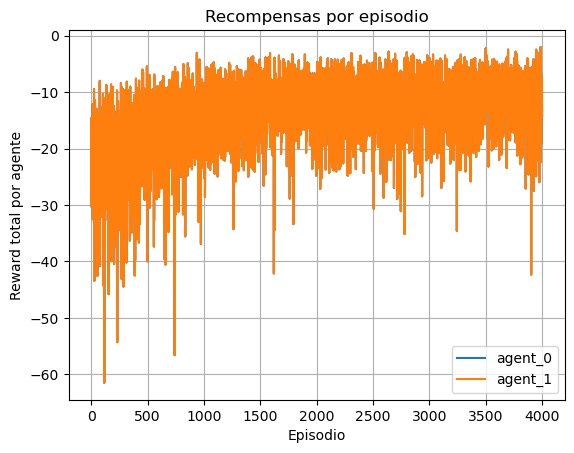

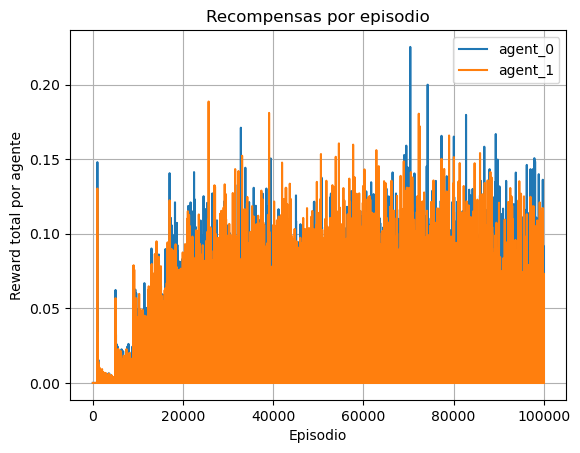

In [81]:
plot_total_rewards(episode_rewards2)
plot_total_rewards(episode_losses2)  # Graficar las pérdidas por episodio

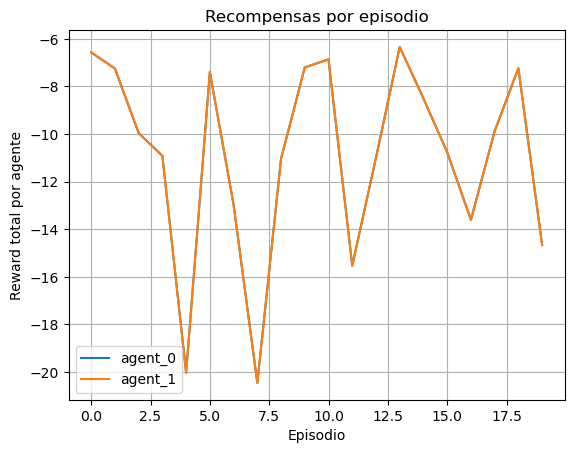

In [82]:
rewards_2 = evaluate_agent_parallel(env, agent_dict, episodes=20)
plot_total_rewards(rewards_2)

In [83]:
evaluate_multiagent_render_parallel(agent_dict, env, num_tests=5, save_path="multiagent_episode_simple_spread2.mp4", fps=5, max_steps=50)

Video guardado en: multiagent_episode_simple_spread2.mp4


# 3 Agents

In [84]:
# Crear entorno paralelo
seed = 42
env = simple_spread_v3.parallel_env(render_mode='rgb_array', N = 3, local_ratio = 0.5, max_cycles=25, dynamic_rescaling=True)
env.reset(seed=seed)
agents = env.agents

dqn_params = {
    "learning_rate": 1e-3,
    "buffer_size": 100000,
    "learning_starts": 1000,
    "batch_size": 128,
    "tau": 1.0,
    "gamma": 0.99,
    "train_freq": 16,
    "gradient_steps": 4,
    "target_update_interval": 1000,
    "exploration_fraction": 0.1,
    "exploration_initial_eps": 1,
    "exploration_final_eps": 0.1,
    "max_grad_norm": 10,
    "verbose": 1,
}

# Inicializar agentes solo para los adversarios
agent_dict = {
    agent: DQN(env, **dqn_params)
    for agent in agents if agent.startswith("agent")
}

# Entrenar los agentes adversarios
episode_rewards3, episode_losses3 = learn_multiagent(env, agent_dict, total_timesteps=100000, log_interval=100)

----------------------------------
| time/               |          |
|    episodes         | 100
|    fps              | 492
|    time_elapsed     | 5
|    total_timesteps  | 2500
|    ep_len_mean      | 25
| agent_0 -> mean_ep_rew | -26.34 | loss: 0.0213 | eps: 0.775
| agent_1 -> mean_ep_rew | -26.40 | loss: 0.0144 | eps: 0.775
| agent_2 -> mean_ep_rew | -26.30 | loss: 0.0198 | eps: 0.775
----------------------------------
----------------------------------
| time/               |          |
|    episodes         | 200
|    fps              | 355
|    time_elapsed     | 14
|    total_timesteps  | 5000
|    ep_len_mean      | 25
| agent_0 -> mean_ep_rew | -27.28 | loss: 0.0148 | eps: 0.550
| agent_1 -> mean_ep_rew | -27.31 | loss: 0.0126 | eps: 0.550
| agent_2 -> mean_ep_rew | -27.38 | loss: 0.0110 | eps: 0.550
----------------------------------
----------------------------------
| time/               |          |
|    episodes         | 300
|    fps              | 319
|    time_elaps

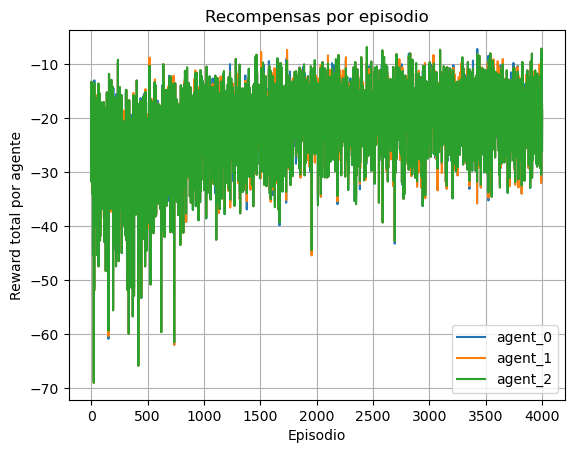

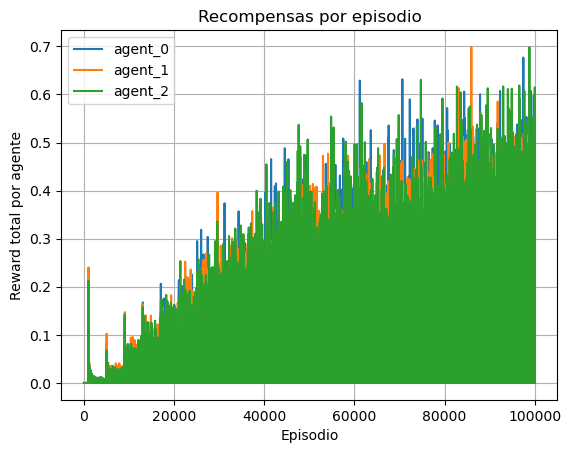

In [85]:
plot_total_rewards(episode_rewards3)
plot_total_rewards(episode_losses3)  # Graficar las pérdidas por episodio

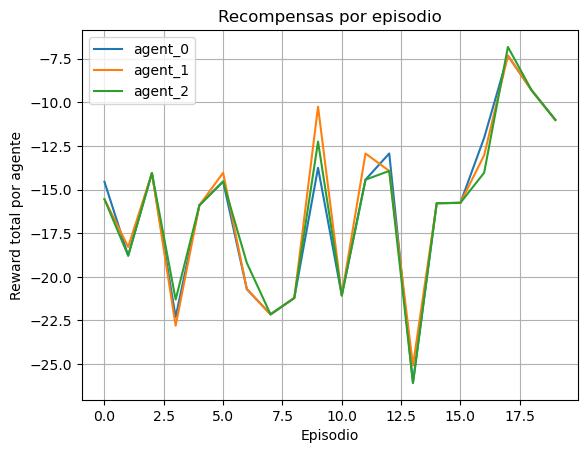

In [86]:
rewards_3 = evaluate_agent_parallel(env, agent_dict, episodes=20)
plot_total_rewards(rewards_3)

In [87]:
evaluate_multiagent_render_parallel(agent_dict, env, num_tests=5, save_path="multiagent_episode_simple_spread3.mp4", fps=5, max_steps=50)

Video guardado en: multiagent_episode_simple_spread3.mp4


## 3 agents and obstacle

In [90]:
# Crear entorno paralelo
seed = 42
env = simple_spread_v3.parallel_env(render_mode='rgb_array', N=3, max_cycles=25, local_ratio=0.5, dynamic_rescaling=True)
env.reset(seed=seed)
agents = env.agents

dqn_params = {
    "learning_rate": 1e-4,
    "buffer_size": 1000000,
    "learning_starts": 5000,
    "batch_size": 128,
    "tau": 1.0,
    "gamma": 0.99,
    "train_freq": 16,
    "gradient_steps": 4,
    "target_update_interval": 2000,
    "exploration_fraction": 0.1,
    "exploration_initial_eps": 1,
    "exploration_final_eps": 0.1,
    "max_grad_norm": 10,
    "verbose": 1,
}

# Inicializar agentes solo para los adversarios
agent_dict = {
    agent: DQN(env, **dqn_params)
    for agent in agents if agent.startswith("agent")
}

# Entrenar los agentes adversarios
episode_rewards4, episode_losses4 = learn_multiagent(env, agent_dict, total_timesteps=150000, log_interval=100)

----------------------------------
| time/               |          |
|    episodes         | 100
|    fps              | 3643
|    time_elapsed     | 0
|    total_timesteps  | 2500
|    ep_len_mean      | 25
| agent_0 -> mean_ep_rew | -26.26 | loss: nan | eps: 0.850
| agent_1 -> mean_ep_rew | -26.21 | loss: nan | eps: 0.850
| agent_2 -> mean_ep_rew | -26.18 | loss: nan | eps: 0.850
----------------------------------
----------------------------------
| time/               |          |
|    episodes         | 200
|    fps              | 2617
|    time_elapsed     | 1
|    total_timesteps  | 5000
|    ep_len_mean      | 25
| agent_0 -> mean_ep_rew | -28.00 | loss: nan | eps: 0.700
| agent_1 -> mean_ep_rew | -27.95 | loss: nan | eps: 0.700
| agent_2 -> mean_ep_rew | -27.99 | loss: nan | eps: 0.700
----------------------------------
----------------------------------
| time/               |          |
|    episodes         | 300
|    fps              | 628
|    time_elapsed     | 11
|    

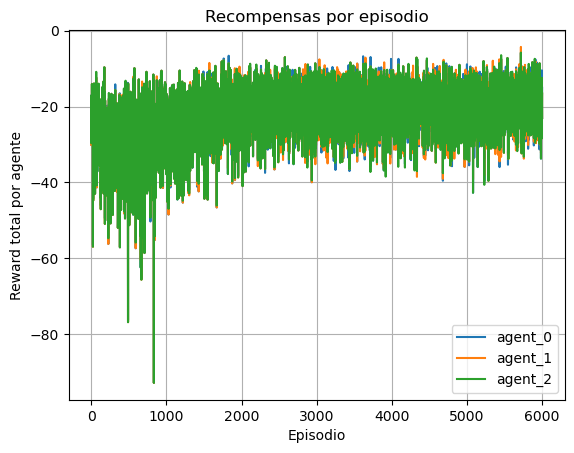

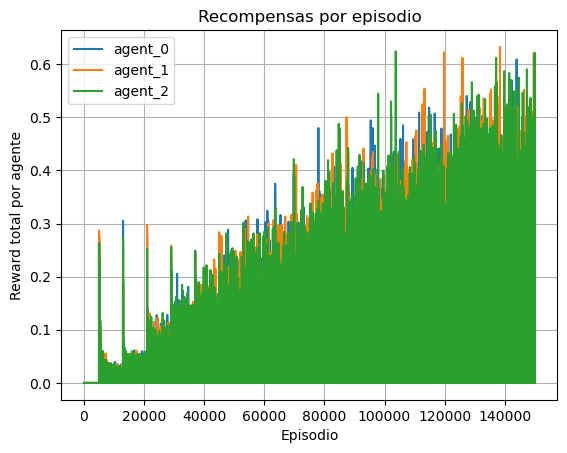

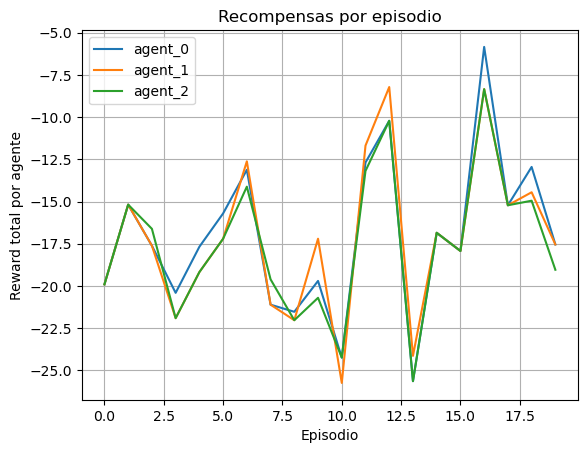

In [91]:
plot_total_rewards(episode_rewards4)
plot_total_rewards(episode_losses4)  # Graficar las pérdidas por episodio
rewards_4 = evaluate_agent_parallel(env, agent_dict, episodes=20)
plot_total_rewards(rewards_4)

In [92]:
evaluate_multiagent_render_parallel(agent_dict, env, num_tests=5, save_path="multiagent_episode_3_obstacles.mp4", fps=5, max_steps=50)

Video guardado en: multiagent_episode_3_obstacles.mp4
